# Image Captioning with Transformers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms as T

In [2]:
import math
from random import randint
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import OrderedDict

In [3]:
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
import timm

In [5]:
# TODO: Try pre trained CLIP

# Download Dataset and Annotations

In [6]:
from torchvision.datasets.utils import download_and_extract_archive

In [7]:
# download_and_extract_archive("http://images.cocodataset.org/zips/train2017.zip",
#                              download_root="../datasets/COCO",
#                              remove_finished=True)

In [8]:
# download_and_extract_archive("http://images.cocodataset.org/zips/val2017.zip",
#                              download_root="../datasets/COCO",
#                              remove_finished=True)

In [9]:
# download_and_extract_archive("http://images.cocodataset.org/annotations/annotations_trainval2017.zip",
#                              download_root="../datasets/COCO",
#                              remove_finished=True)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocessing Transforms

In [11]:
input_size = 224

In [12]:
preproc = {
    'train': T.Compose([
        T.RandomResizedCrop(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.RandomHorizontalFlip(input_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': T.Compose([
        T.Resize(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(input_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define Projection Head

In [13]:
class ProjectionHead(nn.Module):
    def __init__(self, d_model=512, dp_rate=0.1):
        super().__init__()
        self.proj = nn.LazyLinear(d_model)
        self.activation = nn.GELU()
        self.dropout1 = nn.Dropout(dp_rate)
        self.dense = nn.LazyLinear(d_model)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x):   # (..., features)
        p = self.proj(x)
        x = self.dropout1(self.activation(p))
        x = self.dropout2(self.dense(x))
        x = self.ln(x + p)
        return x

In [14]:
# inp = torch.randn((1,3,224,224))

In [15]:
# encoder = timm.create_model('seresnext50_32x4d', pretrained=False, num_classes=0, global_pool='')#, features_only=True)

In [16]:
# out = encoder(inp).flatten(-2).permute(2,0,1)

In [17]:
# out.shape

In [18]:
# ph = ProjectionHead()

In [19]:
# ph(out).shape

# Token Embedding and Positional Encoding layers

In [20]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.scale = emb_size**0.5

    def forward(self, tokens):
        return self.embedding(tokens.long()) * self.scale

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dp_rate, maxlen = 1_000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10_000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dp_rate)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# Freezing encoder parametrs

In [21]:
# https://github.com/fastai/fastai2/blob/8d798c881c1eda564bdf92079bdfe43b43525767/fastai2/callback/training.py
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

def set_bn_eval(m:nn.Module):
    "Set bn layers in eval mode for all recursive children of `m`."
    for l in m.children():
        if isinstance(l, bn_types) and not next(l.parameters()).requires_grad:
            l.eval()
        set_bn_eval(l)

def freeze_weights(m):
    for param in m.parameters():
        param.requires_grad_(False)

# Model class with encoder, projection and decoder

In [22]:
class CaptionModel(nn.Module):
    def __init__(self, vocab_size, num_decoder_layers=6, nheads=8, d_model=512,
                 dim_feedforward=2048, dp_rate=0.1, activation='relu', bn_eval=True):
        super().__init__()
        self.encoder = timm.create_model('seresnext50_32x4d', pretrained=False, num_classes=0, global_pool='')
        freeze_weights(self.encoder)
        if bn_eval: set_bn_eval(self.encoder)
        
        self.projection_head = ProjectionHead(d_model, dp_rate)

        self.tok_emb = TokenEmbedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, dp_rate)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nheads, dim_feedforward, dp_rate,
                                                   activation)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)
        self.generator = nn.Linear(d_model, vocab_size)


    def forward(self, x, tgt, tgt_mask=None, tgt_key_padding_mask=None):   # x[B,C,H,W]  tgt[seq_len,B]
        # Extract Image Features
        x = self.encoder(x)
        # (B, features, h, w)
        x = x.flatten(-2)    # flatten each feature
        # (B, features, h*w)
        x = x.permute(2,0,1)
        # (h*w, B, features)
        x = self.projection_head(x)
        # (h*w, B, d_model)

        # Generate Captions
        tgt = self.pos_enc(self.tok_emb(tgt))
        # (seq_len, B, d_model)
        x = self.decoder(tgt, memory=x, tgt_mask=tgt_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask)
        # (seq_len, B, d_model)
        x = self.generator(x)
        # (seq_len, B, vocab_size)
        return x

# Masking

In [23]:
def subsequent_mask(sz):
    mask = torch.ones((sz,sz), device=device, dtype=bool)
    mask.triu_(1)
    return mask

def padding_mask(tgt, pad_idx):
    return (tgt==pad_idx).transpose(0,1)

# Dataset utils

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext

from collections import Counter

## Read COCO dataset

In [25]:
cap_data = datasets.CocoCaptions(root="../datasets/COCO/val2017/",
                                 annFile="../datasets/COCO/annotations/captions_val2017.json",
                                 transform=preproc['val'])

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


## Tokenizer and Build Vocab

In [36]:
tokenizer = get_tokenizer('basic_english')

In [37]:
def yield_tokens(cap_data):
    for ann in cap_data.coco.anns.values():
        yield tokenizer(ann['caption'])

In [38]:
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
en_vocab = build_vocab_from_iterator(yield_tokens(cap_data), specials=special_symbols, special_first=True)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = en_vocab(special_symbols)
en_vocab.set_default_index(UNK_IDX)

## Pretrained Glove Embeddings

In [65]:
vec = torchtext.vocab.GloVe('6B', dim=300)

In [66]:
unk_vec = vec.vectors.mean(dim=0)

In [67]:
vec.unk_init = lambda x: unk_vec

In [69]:
# vec.get_vecs_by_tokens(tokens, lower_case_backup=True)

# Load dataset into batches

In [43]:
def generate_batch(data_batch):
    img_batch, cap_batch = [], []
    for img, caps in data_batch:
        img_batch.append(img)
        cap = caps[randint(0,len(caps)-1)]
        cap_batch.append(torch.tensor([BOS_IDX] + en_vocab(tokenizer(cap)) + [EOS_IDX]))

    cap_batch = pad_sequence(cap_batch, batch_first=False, padding_value=PAD_IDX)
    return torch.stack(img_batch), cap_batch

In [44]:
BATCH_SIZE = 64

In [45]:
val_loader = torch.utils.data.DataLoader(cap_data,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=3,
                                         pin_memory=True,
                                         collate_fn=generate_batch)

# Model Parameters

In [46]:
import wandb

In [47]:
config_defaults = {
    'tgt_vocab_size'    : len(en_vocab),
    'BATCH_SIZE'        : BATCH_SIZE,
    'd_model'           : 512,
    'dim_feedforward'   : 2048,
    'nheads'            : 8,
    'num_decoder_layers': 6,
    'dp_rate'           : 0.1,
    'activation'        : 'gelu',
    'ilr'               : 1,
    'betas'             : (0.9, 0.98),
    'eps'               : 1e-9,
    'use_amp'           : True,
    'use_pe'            : True,
    'log_interval'      : 5,
}
CONFIG = config_defaults

# Initialize Model

In [48]:
model = CaptionModel(vocab_size = CONFIG['tgt_vocab_size'],
                     num_decoder_layers = CONFIG['num_decoder_layers'],
                     nheads = CONFIG['nheads'],
                     d_model = CONFIG['d_model'],
                     dim_feedforward = CONFIG['dim_feedforward'],
                     dp_rate = CONFIG['dp_rate'],
                     activation = CONFIG['activation']).to(device)

/usr/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [50]:
img, cap = next(iter(val_loader))

In [51]:
img = img.to(device)
cap = cap.to(device)

In [52]:
tgt_mask, tgt_pad_mask = subsequent_mask(cap.size(0)), padding_mask(cap, PAD_IDX)

In [53]:
tgt_mask.shape, tgt_pad_mask.shape

(torch.Size([25, 25]), torch.Size([64, 25]))

In [54]:
o = model(img, cap, tgt_mask, tgt_pad_mask)

/usr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [55]:
o.shape

torch.Size([25, 64, 7316])

# Learning Rate Schedule

In [56]:
def lr_schedule(step, d_model=1024, warmup_steps=4000):
    # return 1
    step = max(1,step)
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    return (d_model ** -0.5) * min(arg1, arg2)

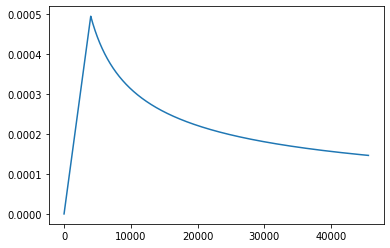

In [57]:
plt.plot(list(map(lr_schedule, range(114*400))))
plt.show()

# Loss Function and Optimizer

In [59]:
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['ilr'], betas=CONFIG['betas'], eps=CONFIG['eps']
)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_schedule)

scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

# Log model

In [60]:
from torch.utils.tensorboard import SummaryWriter

In [61]:
# writer = SummaryWriter(run.dir+'/tensorboard_logs/imcap')

In [62]:
# src, tgt = next(iter(train_iter))
# src = src.to(device)
# tgt = tgt.to(device)
# writer.add_graph(model, (src, tgt))
# writer.close()
# del src, tgt

In [63]:
# wandb.watch(model, log=None)

In [64]:
def train_epoch(model, train_iter, optimizer, scaler, scheduler, epoch=1, use_amp=True, log_interval=10):
    model.train()
    model.encoder.eval()
    losses = 0
    with tqdm(enumerate(train_iter), total=len(train_iter), desc=f"Epoch {epoch}") as pbar:
        for idx, (img, tgt) in pbar:
            img = img.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0)), padding_mask(tgt_inp, PAD_IDX)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(img, tgt_inp, tgt_mask, tgt_pad_mask)
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            losses+= loss.item()
            avg_loss = losses/(idx+1)
            curr_lr = optimizer.param_groups[0]['lr']
            info = {'loss': avg_loss, 'lr': curr_lr}

            if not idx%log_interval:
                wandb.log(info)
            pbar.set_postfix(info)

    return losses/len(train_iter)

In [ ]:
def evaluate(model, val_iter):
    model.eval()
    losses = 0
    with tqdm(enumerate(val_iter), total=len(val_iter), desc="Evaluating") as pbar:
        for idx, (img, tgt) in pbar:
            img = img.to(device)
            tgt = tgt.to(device)

            tgt_inp = tgt[:-1,:]      # give input until before the last word.
            tgt_out = tgt[1:, :]      # predict the last word based on input and already predicted sentence. (auto-regressive)

            tgt_mask, tgt_pad_mask = subsequent_mask(tgt_inp.size(0)), padding_mask(tgt_inp, PAD_IDX)

            logits = model(img, tgt_inp, src_mask, tgt_mask)

            loss = loss_fn(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))

            losses+= loss.item()
            pbar.set_postfix({'val_loss': f"{losses/(idx+1):.3f}"})
    return losses/len(val_iter)